# Predicting Blue-Chip Company Financial Trajectory

### COMS W4995 – Applied Machine Learning

#### **Group 24**: Yu-Heng Chi, Param Sejpal, Jessica Villanueva, Yihan Yang, Zhiyi Zhang

#### **UNI IDs**: yc4548, pns2129, jss2326, yy3528, zz3274

---


### Objective
Our objective is to measure a company’s financial health trajectory indicated by the equity value of the company. This means predicting the annual market cap using annual data (e.g., year-end market cap for 2025).If we predict this metric, we are essentially predicting stock price and shares outstanding. The financial metrics we used are from a 2024 dataset for Fortune 1000 companies, and additional financial metrics we worked with are from 10-K reports found on the SEC database (More information on data sources is in the README.md and project deliverables).

In [145]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression



In [146]:
# Load data
initial_df = pd.read_csv('FinancialData.csv')
initial_df.head()

,Rank,Company,Ticker,Sector,Industry,Profitable,Founder_is_CEO,FemaleCEO,Growth_in_Jobs,Change_in_Rank,...,Country,HeadquartersCity,HeadquartersState,Website,CompanyType,Footnote,MarketCap_Updated_M,Updated,EBITDA,EBITDA_Margin
0,1,Walmart,WMT,Retailing,General Merchandisers,yes,no,no,no,0,...,U.S.,Bentonville,Arkansas,https://www.stock.walmart.com,Public,"Figures are for fiscal year ended Jan. 31, 202...",559911.0,8/5/2024,3.638400e+10,56137.319190
1,2,Amazon,AMZN,Retailing,Internet Services and Retailing,yes,no,no,no,0,...,U.S.,Seattle,Washington,https://www.amazon.com,Public,"Market value as of July 15, 2024.",2005565.0,8/5/2024,1.134840e+11,197437.302644
2,3,Apple,AAPL,Technology,"Computers, Office Equipment",yes,no,no,no,1,...,U.S.,Cupertino,California,https://www.apple.com,Public,"Figures are for fiscal year ended Sept. 30, 20...",3594309.0,8/5/2024,1.346610e+11,351333.863835
3,4,UnitedHealth Group,UNH,Health Care,Health Care: Insurance and Managed Care,yes,no,no,yes,1,...,U.S.,Minnetonka,Minnesota,https://www.unitedhealthgroup.com,Public,"Market value as of July 15, 2024.",474339.0,8/5/2024,2.790400e+10,75087.050820
4,5,Berkshire Hathaway,BRKA,Financials,Insurance: Property and Casualty (Stock),yes,no,no,yes,2,...,U.S.,Omaha,Nebraska,https://www.berkshirehathaway.com,Public,"Market value as of July 15, 2024.",937028.0,8/5/2024,NaN,0.000000


# 1. Data Exploration

### 1.1 Data Summary

We will explore aspects of the dataset, noting any missing data, imbalanced data, and other properties.

In [147]:
# Generate a summary
df.describe()

,Rank,Change_in_Rank,Number_of_employees,MarketCap_March28_M,Revenues_M,RevenuePercentChange,Profits_M,ProfitsPercentChange,Assets_M,MarketCap_Updated_M,EBITDA
count,1000.000000,1000.00000,1.000000e+03,9.590000e+02,1000.000000,994.000000,998.000000,850.000000,1.000000e+03,9.630000e+02,7.620000e+02
mean,500.498000,5.83800,3.661176e+04,5.083890e+04,20965.064200,6.788129,1867.165832,3.348706,6.375722e+04,5.397445e+04,3.999988e+09
std,288.819686,66.88084,9.990100e+04,1.913577e+05,48589.311028,34.918519,6649.887738,938.609539,2.721551e+05,2.292664e+05,1.106741e+10
min,1.000000,-577.00000,2.800000e+01,1.200000e+00,2489.000000,-78.300000,-10298.000000,-22340.000000,3.613000e+02,1.000000e+00,-1.127800e+10
25%,250.750000,-14.00000,6.718000e+03,4.862750e+03,3968.375000,-4.700000,157.575000,-37.575000,5.342950e+03,4.832500e+03,5.973562e+08
50%,500.500000,4.00000,1.400000e+04,1.253230e+04,7090.500000,4.500000,542.600000,-4.150000,1.284765e+04,1.237900e+04,1.355500e+09
75%,750.250000,30.25000,3.074075e+04,3.892385e+04,16207.650000,12.300000,1401.050000,22.900000,3.758012e+04,3.773550e+04,3.519925e+09
max,1000.000000,420.00000,2.100000e+06,3.126133e+06,648125.000000,751.600000,96995.000000,11552.100000,4.325437e+06,3.594309e+06,1.346610e+11


In [148]:
# Gather information on dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Rank                           1000 non-null   int64  
 1   Company                        1000 non-null   object 
 2   Ticker                         959 non-null    object 
 3   Sector                         1000 non-null   object 
 4   Industry                       1000 non-null   object 
 5   Profitable                     1000 non-null   object 
 6   Founder_is_CEO                 1000 non-null   object 
 7   FemaleCEO                      1000 non-null   object 
 8   Growth_in_Jobs                 1000 non-null   object 
 9   Change_in_Rank                 1000 non-null   int64  
 10  Gained_in_Rank                 1000 non-null   object 
 11  Dropped_in_Rank                1000 non-null   object 
 12  Newcomer_to_the_Fortune500     500 non-null    ob

### 1.2 Removing Columns

Our **target** variable that we are aiming to predict is "MarketCapF1". We have the following features that are relevant for predicting this variable:

1. Metrics describing *revenue* (e.g., Revenues_M, RevenuePercentChange).
2. Metrics describing *profit*(e.g., Profits_M, ProfitsPercentChange).
3. Metrics describing *company* assets (e.g., Assets_M, Cash Flow from Operations).
4. Metrics describing *employees* (e.g., Number_of_employees, EBITDA per employee).

And the other features (Worlds_Most_Admired_Companies, Best_Companies_to_Work_For, and other features) are generally irrelevant for predicting financial metrics like Market Cap.

In [149]:
# Define the list of irrelevant columns to remove
removed_columns = [
    'Company', 'Rank', 'CEO', 'Founder_is_CEO', 'Growth_in_Jobs', 'Change_in_Rank', 'Gained_in_Rank', 'Global500',
    'Dropped_in_Rank', 'Newcomer_to_the_Fortune500','FemaleCEO', 'Worlds_Most_Admired_Companies', 'Footnote',
    'Best_Companies_to_Work_For',  'Country', 'HeadquartersCity', 'HeadquartersState', 'Website', 'Updated'
]

df = initial_df.drop(columns=removed_columns, errors='ignore')
df.head()

,Ticker,Sector,Industry,Profitable,Number_of_employees,MarketCap_March28_M,Revenues_M,RevenuePercentChange,Profits_M,ProfitsPercentChange,Assets_M,CompanyType,MarketCap_Updated_M,EBITDA,EBITDA_Margin
0,WMT,Retailing,General Merchandisers,yes,2100000,484852.8,648125.0,6.0,15511.0,32.8,252399.0,Public,559911.0,3.638400e+10,56137.319190
1,AMZN,Retailing,Internet Services and Retailing,yes,1525000,1873675.8,574785.0,11.8,30425.0,NaN,527854.0,Public,2005565.0,1.134840e+11,197437.302644
2,AAPL,Technology,"Computers, Office Equipment",yes,161000,2647973.8,383285.0,-2.8,96995.0,-2.8,352583.0,Public,3594309.0,1.346610e+11,351333.863835
3,UNH,Health Care,Health Care: Insurance and Managed Care,yes,440000,456080.8,371622.0,14.6,22381.0,11.2,273720.0,Public,474339.0,2.790400e+10,75087.050820
4,BRKA,Financials,Insurance: Property and Casualty (Stock),yes,396500,908919.7,364482.0,20.7,96223.0,NaN,1069978.0,Public,937028.0,NaN,0.000000


## 2. Data Preprocessing
Given some of the missing data in the dataset, including unnamed columns, and data that is irrelevant to determining financial metrics, we will remove certain columns. Additionally, we will **impute** data that is missing in our dataset. Lastly, there are certain elements in the dataset that are not necessary for predicting financial metrics or are heavily correlated with others. 

### 2.1 Data Cleaning
Other parts of the dataset (company ticker symbol, "MarketCap_March28_M", "MarketCap_Updated_M") have a low amount of missing values. We will delete these values because a very low number is missing from the total data.

In [150]:
# Check for missing data
df.isnull().sum()

Ticker                   41
Sector                    0
Industry                  0
Profitable                0
Number_of_employees       0
MarketCap_March28_M      41
Revenues_M                0
RevenuePercentChange      6
Profits_M                 2
ProfitsPercentChange    150
Assets_M                  0
CompanyType               0
MarketCap_Updated_M      37
EBITDA                  150
EBITDA_Margin             0
dtype: int64

We drop the rows with missing values for "MarketCap_March28_M" and impute the values for "RevenuePercentChange," "Profits_M," and "ProfitsPercentChange." We are using the median for imputing the values of these metrics because financial data tends to be skewed. 

In [151]:
df = df.dropna(subset=['MarketCap_March28_M'])
df = df.dropna(subset=['Ticker'])
df['RevenuePercentChange'] = df['RevenuePercentChange'].fillna(df['RevenuePercentChange'].median())
df['Profits_M'] = df['Profits_M'].fillna(df['Profits_M'].median())
df['ProfitsPercentChange'] = df['ProfitsPercentChange'].fillna(df['ProfitsPercentChange'].median())


In [152]:
# checking for missing values again

if df.isnull().sum().sum() == 0:
    print("No missing values!")
else:
    print(df.isnull().sum())


Ticker                    0
Sector                    0
Industry                  0
Profitable                0
Number_of_employees       0
MarketCap_March28_M       0
Revenues_M                0
RevenuePercentChange      0
Profits_M                 0
ProfitsPercentChange      0
Assets_M                  0
CompanyType               0
MarketCap_Updated_M       0
EBITDA                  108
EBITDA_Margin             0
dtype: int64


### 2.3 Feature Engineering:
We will add metrics we will need for predicting market cap and for classifying financial health of a company, including:

- Revenue Growth
- Profit Margin
- Profit Growth
- Employee Efficiency (Revenue per employee)

In [153]:
# Regression-related metrics for predicting Market Cap
df['Revenue_Growth'] = df.groupby('Ticker')['Revenues_M'].pct_change() * 100  # Revenue growth in percentage
df['Profit_Margin'] = df['Profits_M'] / df['Revenues_M']  # Profit margin

# Company growth metrics outlined in deliverable 2
df['Profit_Growth'] = df.groupby('Ticker')['Profits_M'].pct_change() * 100  # Profit growth
df['Revenue_per_Employee'] = df['Revenues_M'] / df['Number_of_employees']  # Revenue per employee

# Growth references the year before so the first value returns a !#REF error
df['Revenue_Growth'] = df['Revenue_Growth'].fillna(0)
df['Profit_Growth'] = df['Profit_Growth'].fillna(0)

print(df.head())

  Ticker       Sector                                  Industry Profitable  \
0    WMT    Retailing                     General Merchandisers        yes   
1   AMZN    Retailing           Internet Services and Retailing        yes   
2   AAPL   Technology               Computers, Office Equipment        yes   
3    UNH  Health Care   Health Care: Insurance and Managed Care        yes   
4   BRKA   Financials  Insurance: Property and Casualty (Stock)        yes   

   Number_of_employees  MarketCap_March28_M  Revenues_M  RevenuePercentChange  \
0              2100000             484852.8    648125.0                   6.0   
1              1525000            1873675.8    574785.0                  11.8   
2               161000            2647973.8    383285.0                  -2.8   
3               440000             456080.8    371622.0                  14.6   
4               396500             908919.7    364482.0                  20.7   

   Profits_M  ProfitsPercentChange   Assets_

## 3. Preprocessing
Split the data, scale numerical variables, encode categorical variables.

### 3.1 Define target and features

In [154]:
# Define numeric columns to normalize
num_features = ['EBITDA', 'Revenue_Growth', 'Profit_Margin', 'Profit_Growth', 'Revenue_per_Employee', 
                     'MarketCap_March28_M', 'Revenues_M', 'Profits_M', 'Assets_M', 'MarketCap_Updated_M']


X = df[num_features]
y = df['MarketCap_March28_M']  # Target variable

### 3.2 Split data

We split the data into development and test sets (80/20).

In [155]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3.3 Encoding
Convert categorical features into numerical values.

In [156]:
# One Hot Encode categorical variables
df = pd.get_dummies(df, columns=['Sector', 'Industry', 'CompanyType'], drop_first=True)

print(df.head())

  Ticker Profitable  Number_of_employees  MarketCap_March28_M  Revenues_M  \
0    WMT        yes              2100000             484852.8    648125.0   
1   AMZN        yes              1525000            1873675.8    574785.0   
2   AAPL        yes               161000            2647973.8    383285.0   
3    UNH        yes               440000             456080.8    371622.0   
4   BRKA        yes               396500             908919.7    364482.0   

   RevenuePercentChange  Profits_M  ProfitsPercentChange   Assets_M  \
0                   6.0    15511.0                  32.8   252399.0   
1                  11.8    30425.0                  -4.0   527854.0   
2                  -2.8    96995.0                  -2.8   352583.0   
3                  14.6    22381.0                  11.2   273720.0   
4                  20.7    96223.0                  -4.0  1069978.0   

   MarketCap_Updated_M  ...  Industry_Transportation Equipment  \
0             559911.0  ...                 

### 3.4 Scale Numerical Features

In [157]:
# scale data

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

---

## 4. Exploratory Data Analysis (EDA)

In [158]:
# convert back to pandas df

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_features)
print(X_train_scaled.head())

     EBITDA  Revenue_Growth  Profit_Margin  Profit_Growth  \
0 -0.169369             0.0      -0.008715            0.0   
1 -0.394184             0.0      -3.647321            0.0   
2 -0.223762             0.0       0.934951            0.0   
3  0.206490             0.0       0.384907            0.0   
4  0.081701             0.0      -0.155515            0.0   

   Revenue_per_Employee  MarketCap_March28_M  Revenues_M  Profits_M  Assets_M  \
0             -0.299030            -0.175031   -0.174487  -0.137792 -0.183645   
1             -0.044299            -0.146583   -0.363231  -0.435888 -0.194283   
2             -0.338198            -0.124353   -0.344904  -0.172735 -0.203800   
3              0.438278             0.008930    0.242025   0.363807 -0.104902   
4             -0.113002            -0.118761    0.580364   0.162758 -0.089940   

   MarketCap_Updated_M  
0            -0.162197  
1            -0.137760  
2            -0.118665  
3            -0.023871  
4            -0.08332

### 4.1 Feature Correlation

Datasets such as financial data are oftentimes imbalanced because [explanation].
explanation on correlated features i.e. these features are correlated because.... 

explanation on which one(s) we are dropping and if we will keep any and just use L2 regression or somthing

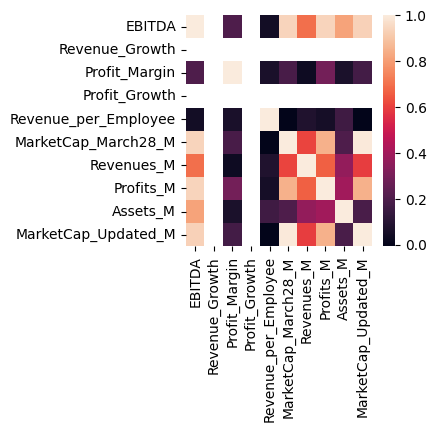

In [159]:
# Correlation matrix 
# TODO: this needs work

plt.figure(figsize=(3, 3))
sns.heatmap(X_train.corr())


plt.show()


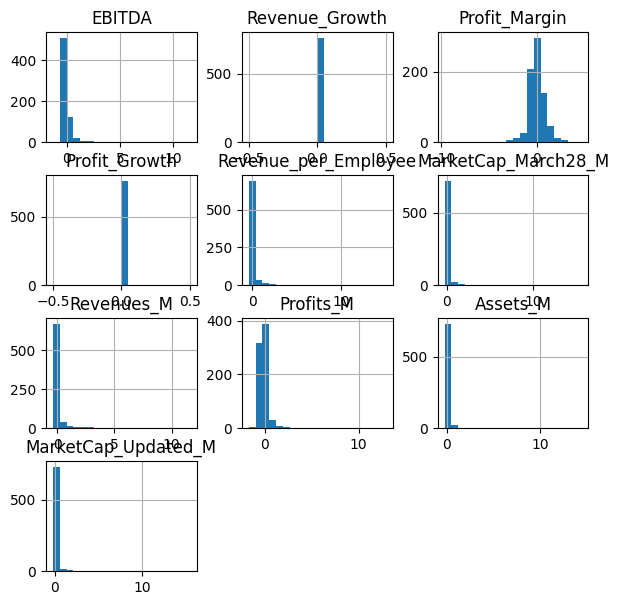

In [160]:
# Numerical features histogram plots


X_train_scaled.hist(bins=20, figsize=(7, 7))

plt.title("Numerical Feature Distributions by Company")

# need labels for x and y here

plt.show()


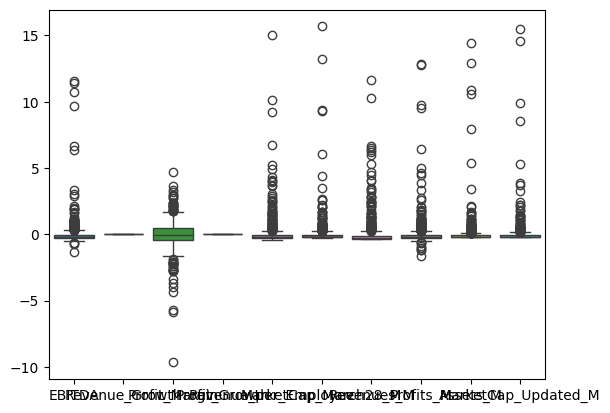

In [161]:
# Investigate outliers in data

sns.boxplot(data=X_train_scaled)
plt.show()


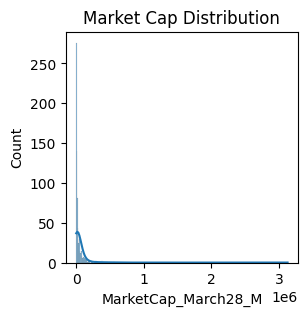

In [162]:
# Market Cap distribution
plt.figure(figsize=(3, 3))
sns.histplot(y_train, kde=True)
plt.title('Market Cap Distribution')
plt.show()


## 5 Regression Models

### Regression Objective

We aim to predict annual Market Cap based on the financial metrics in our data. We will do this using several models and applying the supervised learning framework, which will include training the model, tuning hyperparamters, and evaluating performance.

## 5.1 Hyperparameter Tuning

### 5.1.1 Random Forest

In [163]:
rf = RandomForestRegressor()

# TODO: experiment w different values
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=5, n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train, y_train)
print("Best Random Forest parameters:", rf_grid_search.best_params_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[

### 5.1.2 Gradient Boost

In [164]:

gb = GradientBoostingRegressor()

# TODO: experiment w different values
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search
gb_grid_search = GridSearchCV(estimator=gb, param_grid=gb_param_grid, cv=5)
gb_grid_search.fit(X_train, y_train)

# Best parameters
print("Best Gradient Boosting parameters:", gb_grid_search.best_params_)


ValueError: 
All the 1215 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1215 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/sadievilla/F2024/myenv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sadievilla/F2024/myenv/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sadievilla/F2024/myenv/lib/python3.11/site-packages/sklearn/ensemble/_gb.py", line 659, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/sadievilla/F2024/myenv/lib/python3.11/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sadievilla/F2024/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1301, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/Users/sadievilla/F2024/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1064, in check_array
    _assert_all_finite(
  File "/Users/sadievilla/F2024/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py", line 123, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/sadievilla/F2024/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py", line 172, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
GradientBoostingRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


### 5.1.3 XGBoost

In [ ]:
xg = xgb.XGBRegressor()
# Note: `brew install libomp` fixes the "You are running 32-bit Python on a 64-bit OS" issue

# TODO: experiment w different values 
xg_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xg_grid_search = GridSearchCV(estimator=xg, param_grid=xg_param_grid, cv=5)
xg_grid_search.fit(X_train, y_train)
print("Best XGBoost Parameters:", xg_grid_search.best_params_)

Best XGBoost Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


## 5.2 Model Training

For predicting financial metric values themselves, we will implement linear regression, random forest regression, and gradient boosting regression.

### 5.2.1 Linear Regression

In [ ]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)

In [ ]:
# Report RMSE and R^2 scores

print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Linear Regression R^2:", r2_score(y_test, y_pred))

Linear Regression RMSE: 3.0586973051650035e-10
Linear Regression R^2: 1.0


### 5.2.2 Random Forest Regression

In [ ]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Report RMSE and R^2 scores

y_pred_rf = rf.predict(X_test_scaled)
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest R^2:", r2_score(y_test, y_pred_rf))

Random Forest RMSE: 8895.35632742163
Random Forest R^2: 0.9973489551968993


### 5.2.3 Gradient Boosting Regression

In [ ]:
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train_scaled, y_train)
y_pred_gb = gb.predict(X_test_scaled)

In [ ]:
# Report RMSE and R^2 scores
print("Gradient Boosting RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gb)))
print("Gradient Boosting R^2:", r2_score(y_test, y_pred_gb))

Gradient Boosting RMSE: 8450.293131905
Gradient Boosting R^2: 0.9976075993203745


In [ ]:
# Train models with grid search parameters

rf_best_model = rf_grid_search.best_estimator_
gb_best_model = gb_grid_search.best_estimator_
xg_best_model = xg_grid_search.best_estimator_

## 5.2 Evaluation

### 5.2.1 Regression Model Performance

In [ ]:
# Evaluate the regression models

rf_pred = rf_best_model.predict(X_test)
gb_pred = gb_best_model.predict(X_test)
xg_pred = xg_best_model.predict(X_test)

# Find R^2 and RMSE Values:
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

gb_rmse = np.sqrt(mean_squared_error(y_test, gb_pred))
gb_r2 = r2_score(y_test, gb_pred)

xg_rmse = np.sqrt(mean_squared_error(y_test, xg_pred))
xg_r2 = r2_score(y_test, xg_pred)


print(f"Random Forest RMSE: {rf_rmse}, R^2: {rf_r2}")
print(f"Gradient Boosting RMSE: {gb_rmse}, R^2: {gb_r2}")
print(f"XGBoost RMSE: {xg_rmse}, R^2: {xg_r2}")



Random Forest RMSE: 7229.079233730622, R^2: 0.99824912017736
Gradient Boosting RMSE: 3927.450335680279, R^2: 0.9994832127717812
XGBoost RMSE: 6396.426458457884, R^2: 0.9986292281086646


### 5.2.2 Cross-Validation

In [ ]:
rf_cv_score = cross_val_score(rf_best_model, X, y, cv=5, scoring='neg_mean_squared_error')
gb_cv_score = cross_val_score(gb_best_model, X, y, cv=5, scoring='neg_mean_squared_error')
xg_cv_score = cross_val_score(xg_best_model, X, y, cv=5, scoring='neg_mean_squared_error')

print(f"Random Forest Cross-Validation RMSE: {np.sqrt(-rf_cv_score.mean())}")
print(f"Gradient Boosting Cross-Validation RMSE: {np.sqrt(-gb_cv_score.mean())}")
print(f"XGBoost Cross-Validation RMSE: {np.sqrt(-xg_cv_score.mean())}")


Random Forest Cross-Validation RMSE: 169282.84874744414
Gradient Boosting Cross-Validation RMSE: 166574.5226724055
XGBoost Cross-Validation RMSE: 171065.28409998343


---

## Classification Models

### Classification Objective

The variable we predicted, Market Cap, is one of several financial metrics that indicate a company's financial outlook, as changes in this value represent how much growth year over year. For classifying whether a company is financially healthy, we will use classification to place companies into **"growth"** or **"non-growth"**. For the purpose of accuracy, we will classify based on their **EBITDA margins** rather than Market Cap, although both metrics are relevant to considering a company's financial health trajectory. 

### Data Imbalance
These are all Fortune1000 companies, so they will lack sudden market events like bankruptcy and most likely be growing. Therefore, "growth" companies will be the majority class. We will apply stratified splitting (is this needed??) given the imbalanced nature of the dataset and use SMOTE due to this heavy imbalance. 

### Models

TODO: Need to choose which models (we could implement logistic regression and gradient boosting.)